In [1]:
from google.colab import drive
# Mount Google Drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import model_to_dot
from PIL import Image
from keras.applications import ResNet152V2
from keras.models import Sequential
from keras.layers import GaussianNoise, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten

In [3]:
#! unzip "/content/gdrive/MyDrive/25K.zip" #
! unzip "/content/gdrive/MyDrive/50K.zip" #

Streaming output truncated to the last 5000 lines.
 extracting: NSCLC_Radiomics_50k_TTV/validation/Squamous_cell_carcinoma/Squamous_cell_carcinoma_11852.png  
 extracting: NSCLC_Radiomics_50k_TTV/validation/Squamous_cell_carcinoma/Squamous_cell_carcinoma_11854.png  
 extracting: NSCLC_Radiomics_50k_TTV/validation/Squamous_cell_carcinoma/Squamous_cell_carcinoma_11856.png  
 extracting: NSCLC_Radiomics_50k_TTV/validation/Squamous_cell_carcinoma/Squamous_cell_carcinoma_11857.png  
 extracting: NSCLC_Radiomics_50k_TTV/validation/Squamous_cell_carcinoma/Squamous_cell_carcinoma_11861.png  
 extracting: NSCLC_Radiomics_50k_TTV/validation/Squamous_cell_carcinoma/Squamous_cell_carcinoma_11864.png  
 extracting: NSCLC_Radiomics_50k_TTV/validation/Squamous_cell_carcinoma/Squamous_cell_carcinoma_11866.png  
 extracting: NSCLC_Radiomics_50k_TTV/validation/Squamous_cell_carcinoma/Squamous_cell_carcinoma_11867.png  
 extracting: NSCLC_Radiomics_50k_TTV/validation/Squamous_cell_carcinoma/Squamous_cell

In [4]:
#path = "/content/NSCLC_Radiomics_50k_splitted2" #25K
path = "/content/NSCLC_Radiomics_50k_TTV" #50K + cost sensitive

In [5]:
train_ds = keras.utils.image_dataset_from_directory(
    f"{path}/train",
    labels='inferred',
    label_mode='int',
    batch_size=64,
    image_size=(300, 300)

)

test_ds = keras.utils.image_dataset_from_directory(
    f"{path}/test",
    labels='inferred',
    label_mode='int',
    batch_size=64,
    image_size=(300, 300)

)

val_ds = keras.utils.image_dataset_from_directory(
    f"{path}/validation",
    labels='inferred',
    label_mode='int',
    batch_size=64,
    image_size=(300, 300)

)

Found 20485 files belonging to 5 classes.
Found 15364 files belonging to 5 classes.
Found 15366 files belonging to 5 classes.


In [6]:
# Define the new image size
new_image_size = (80, 80)

# Function to resize images
def resize_image(image, label):
    image = tf.image.resize(image, new_image_size)
    return image, label

# Apply resizing to the datasets
train_ds = train_ds.map(resize_image)
test_ds = test_ds.map(resize_image)
val_ds = val_ds.map(resize_image)

In [7]:
# Normalize the pixel values
def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)  # Convert to float32
    image = image / 255.0  # Normalize pixel values
    return image, label

# Apply preprocessing to the datasets
train_ds = train_ds.map(preprocess)
test_ds = test_ds.map(preprocess)
val_ds = val_ds.map(preprocess)

# One-hot encode the labels
num_classes = 5  # Update with the actual number of classes
train_ds = train_ds.map(lambda image, label: (image, tf.one_hot(label, num_classes)))
test_ds = test_ds.map(lambda image, label: (image, tf.one_hot(label, num_classes)))
val_ds = val_ds.map(lambda image, label: (image, tf.one_hot(label, num_classes)))

# Configure the datasets for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [8]:
total_images = 51215
class_frequencies = {
    0: 6018,  # Adenocarcinoma
    1: 13655,  # Large_cell_carcinoma
    2: 5130,   # Normal
    3: 7643,   # Not_otherwise_specified
    4: 18769   # Squamous_cell_carcinoma
}

# Calculate class weights for imbalanced classes
class_weights = {}
total_samples = sum(class_frequencies.values())

for cls, num_samples in class_frequencies.items():
    weight = total_samples / (len(class_frequencies) * num_samples)
    class_weights[cls] = weight

print("Calculated Class Weights for Imbalanced Classes:", class_weights)

Calculated Class Weights for Imbalanced Classes: {0: 1.7020604852110335, 1: 0.7501281581838155, 2: 1.9966861598440546, 3: 1.3401805573727594, 4: 0.545740316479301}


In [9]:
patch_size = (1, 1)
dropout_rate = 0.05
num_heads = 4
embed_dim = 128  # Higher embedding dimension
num_mlp = 64  # Larger MLP layer
qkv_bias = True  # Keep the same
window_size = 2  # Larger attention window
shift_size = 1  # Larger shift size
image_dimension = 80  # Initial image size
input_shape = (80, 80, 3)

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 0.001
batch_size = 64
num_epochs = 100  # More epochs
weight_decay = 0.0001
label_smoothing = 0.1

In [10]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    new_height = patch_num_y * window_size
    new_width = patch_num_x * window_size
    x = x[:, :new_height, :new_width, :]  # Trim the input tensor to match the new shape
    x = tf.reshape(
        x, shape=(-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        shape=(-1, patch_num_y, patch_num_x, window_size, window_size, channels),
    )
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x


class DropPath(layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output

In [11]:
class WindowAttention(layers.Layer):
    def __init__(
        self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs
    ):
        super().__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

    def build(self, input_shape):
        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(
            self.relative_position_index, shape=(-1,)
        )
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, relative_position_index_flat
        )
        relative_position_bias = tf.reshape(
            relative_position_bias, shape=(num_window_elements, num_window_elements, -1)
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32
            )
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size))
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv

In [12]:
class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=2,
        shift_size=1,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size]
            )
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=(-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(
            attn_windows, shape=(-1, self.window_size, self.window_size, channels)
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x

In [13]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size_x, self.patch_size_y, 1),
            strides=(1, self.patch_size_x, self.patch_size_y, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super().__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.shape

        if height % 2 != 0 or width % 2 != 0:
            raise ValueError("Input dimensions must be divisible by 2 for patch merging")

        x = tf.reshape(x, shape=(-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)

In [14]:
input = layers.Input(input_shape)
x = layers.RandomCrop(image_dimension, image_dimension)(input)
x = layers.RandomFlip("horizontal")(x)
x = PatchExtract(patch_size)(x)
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(num_classes, activation="softmax")(x)

In [15]:
swin = keras.Model(input, output)
swin.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 random_crop (RandomCrop)    (None, 80, 80, 3)         0         
                                                                 
 random_flip (RandomFlip)    (None, 80, 80, 3)         0         
                                                                 
 patch_extract (PatchExtrac  (None, 6400, 3)           0         
 t)                                                              
                                                                 
 patch_embedding (PatchEmbe  (None, 6400, 128)         819712    
 dding)                                                          
                                                                 
 swin_transformer (SwinTran  (None, 6400, 128)         83188 

In [16]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # You can choose any metric to monitor
    patience=30,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True  # Do restore best weights
)

# Compile the model
swin.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_categorical_accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.CosineSimilarity(name='cosine_similarity')
    ]
)

# Initialize variables to keep track of the best validation loss and corresponding model weights
best_val_loss = float('inf')
best_weights = None

# Lists to store training and validation metrics
swin_train_losses = []
swin_val_losses = []
swin_train_accuracies = []
swin_val_accuracies = []
swin_train_precisions = []
swin_val_precisions = []
swin_train_recalls = []
swin_val_recalls = []
swin_train_cosine_similarity = []
swin_val_cosine_similarity = []

for epoch in range(200):
    # Train the model for one epoch
    history = swin.fit(train_ds, epochs=1, validation_data=val_ds,steps_per_epoch = 100, callbacks=[early_stopping],class_weight = class_weights)
    #history = swin.fit(train_ds, epochs=1, validation_data=val_ds,steps_per_epoch = 100, callbacks=[early_stopping])
    # Append training and validation metrics for plotting
    swin_train_losses.append(history.history['loss'][0])
    swin_val_losses.append(history.history['val_loss'][0])
    swin_train_accuracies.append(history.history['categorical_accuracy'][0])
    swin_val_accuracies.append(history.history['val_categorical_accuracy'][0])
    swin_train_precisions.append(history.history['precision'][0])
    swin_val_precisions.append(history.history['val_precision'][0])
    swin_train_recalls.append(history.history['recall'][0])
    swin_val_recalls.append(history.history['val_recall'][0])
    swin_train_cosine_similarity.append(history.history['cosine_similarity'][0])
    swin_val_cosine_similarity.append(history.history['val_cosine_similarity'][0])

    # Check if the current validation loss is better than the best seen so far
    if history.history['val_loss'][0] < best_val_loss:
        best_val_loss = history.history['val_loss'][0]
        best_weights = swin.get_weights()
        # You can also save the weights to a file here if desired

# After training, you can set the model weights to the best weights
swin.set_weights(best_weights)

# Now you have the training and validation metrics (loss, accuracy, precision, recall, and cosine similarity) stored in the respective lists.

100/100 [==============================] - 145s 1s/step - loss: 1.6024 - categorical_accuracy: 0.1494 - top_5_categorical_accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - cosine_similarity: 0.4476 - val_loss: 1.6159 - val_categorical_accuracy: 0.1430 - val_top_5_categorical_accuracy: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_cosine_similarity: 0.4435


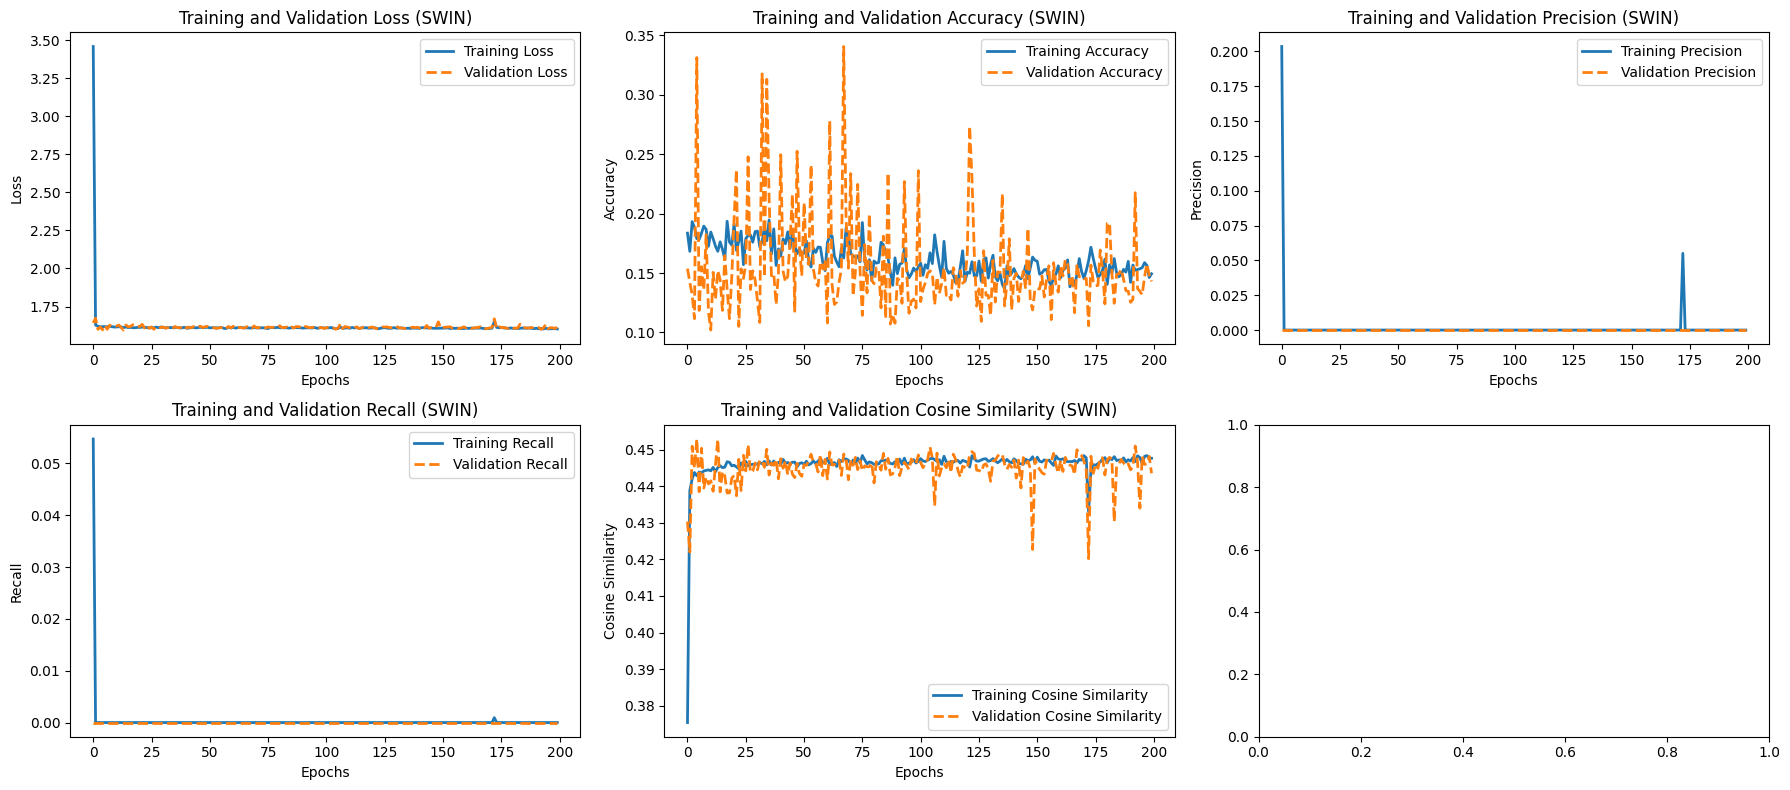

In [17]:
import matplotlib.pyplot as plt

# Create a single figure for all subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Plot training and validation loss
axes[0, 0].plot(swin_train_losses, label='Training Loss', linestyle='-', linewidth=2)
axes[0, 0].plot(swin_val_losses, label='Validation Loss', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].set_title('Training and Validation Loss (SWIN)')

# Plot training and validation accuracy
axes[0, 1].plot(swin_train_accuracies, label='Training Accuracy', linestyle='-', linewidth=2)
axes[0, 1].plot(swin_val_accuracies, label='Validation Accuracy', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].set_title('Training and Validation Accuracy (SWIN)')

# Plot precision, recall, and cosine similarity
axes[0, 2].plot(swin_train_precisions, label='Training Precision', linestyle='-', linewidth=2)
axes[0, 2].plot(swin_val_precisions, label='Validation Precision', linestyle='--', linewidth=2)
axes[0, 2].set_xlabel('Epochs')
axes[0, 2].set_ylabel('Precision')
axes[0, 2].legend()
axes[0, 2].set_title('Training and Validation Precision (SWIN)')

axes[1, 0].plot(swin_train_recalls, label='Training Recall', linestyle='-', linewidth=2)
axes[1, 0].plot(swin_val_recalls, label='Validation Recall', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].legend()
axes[1, 0].set_title('Training and Validation Recall (SWIN)')

axes[1, 1].plot(swin_train_cosine_similarity, label='Training Cosine Similarity', linestyle='-', linewidth=2)
axes[1, 1].plot(swin_val_cosine_similarity, label='Validation Cosine Similarity', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Cosine Similarity')
axes[1, 1].legend()
axes[1, 1].set_title('Training and Validation Cosine Similarity (SWIN)')

# Ensure that the layout is tight
plt.tight_layout()

plt.show()

In [24]:
num_classes = 5
num_positions = 144  # Example for 18x18 image patches
input_shape = (80, 80, 3)
learning_rate = 0.001
weight_decay = 0.0001  # Increase weight decay if overfitting occurs
batch_size = 64
num_epochs = 100
image_size = 80
patch_size = 12
# Increase model complexity
transformer_layers = 1  # Increase the number of Transformer layers
projection_dim = 256    # Increase projection dimension
num_heads = 4
num_patches = (image_size // patch_size) ** 2
transformer_units = [projection_dim , projection_dim]
mlp_head_units = [256, 128, 64]  # Increase MLP size
          # Increase the number of attention heads

In [25]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [26]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [27]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [28]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)

    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = layers.Dropout(0.1)(x3)  # Adjust dropout rate
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # MLP head
    mlp = layers.Dense(1024, activation="relu")(representation)  # You can modify the size of the MLP
    mlp = layers.Dropout(0.5)(mlp)
    mlp = layers.Dense(512, activation="relu")(representation)  # You can modify the size of the MLP
    mlp = layers.Dropout(0.5)(mlp)
    mlp = layers.Dense(256, activation="relu")(representation)  # You can modify the size of the MLP
    mlp = layers.Dropout(0.5)(mlp)
    mlp = layers.Dense(128, activation="relu")(mlp)  # Add more dense layers as needed

    # Classify outputs.
    logits = layers.Dense(num_classes, activation="softmax")(mlp)  # Output layer for classification

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [29]:
vit = create_vit_classifier()
vit.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 80, 80, 3)]          0         []                            
                                                                                                  
 patches_1 (Patches)         (None, None, 432)            0         ['input_3[0][0]']             
                                                                                                  
 patch_encoder_1 (PatchEnco  (None, 36, 256)              120064    ['patches_1[0][0]']           
 der)                                                                                             
                                                                                                  
 layer_normalization_25 (La  (None, 36, 256)              512       ['patch_encoder_1[0][0]'

In [30]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # You can choose any metric to monitor
    patience=30,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True  # Do restore best weights
)

# Compile the model
vit.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_categorical_accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.CosineSimilarity(name='cosine_similarity')
    ]
)

# Initialize variables to keep track of the best validation loss and corresponding model weights
best_val_loss = float('inf')
best_weights = None

# Lists to store training and validation metrics
vit_train_losses = []
vit_val_losses = []
vit_train_accuracies = []
vit_val_accuracies = []
vit_train_precisions = []
vit_val_precisions = []
vit_train_recalls = []
vit_val_recalls = []
vit_train_cosine_similarity = []
vit_val_cosine_similarity = []

for epoch in range(200):
    # Train the model for one epoch
    history = vit.fit(train_ds, epochs=1, validation_data=val_ds,steps_per_epoch = 100, callbacks=[early_stopping],class_weight = class_weights)
    #history = vit.fit(train_ds, epochs=1, validation_data=val_ds,steps_per_epoch = 100, callbacks=[early_stopping])
    # Append training and validation metrics for plotting
    vit_train_losses.append(history.history['loss'][0])
    vit_val_losses.append(history.history['val_loss'][0])
    vit_train_accuracies.append(history.history['categorical_accuracy'][0])
    vit_val_accuracies.append(history.history['val_categorical_accuracy'][0])
    vit_train_precisions.append(history.history['precision'][0])
    vit_val_precisions.append(history.history['val_precision'][0])
    vit_train_recalls.append(history.history['recall'][0])
    vit_val_recalls.append(history.history['val_recall'][0])
    vit_train_cosine_similarity.append(history.history['cosine_similarity'][0])
    vit_val_cosine_similarity.append(history.history['val_cosine_similarity'][0])

    # Check if the current validation loss is better than the best seen so far
    if history.history['val_loss'][0] < best_val_loss:
        best_val_loss = history.history['val_loss'][0]
        best_weights = vit.get_weights()
        # You can also save the weights to a file here if desired

# After training, you can set the model weights to the best weights
vit.set_weights(best_weights)

# Now you have the training and validation metrics (loss, accuracy, precision, recall, and cosine similarity) stored in the respective lists.

100/100 [==============================] - 5s 45ms/step - loss: 1.6080 - categorical_accuracy: 0.1553 - top_5_categorical_accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - cosine_similarity: 0.4471 - val_loss: 1.6098 - val_categorical_accuracy: 0.1492 - val_top_5_categorical_accuracy: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_cosine_similarity: 0.4470


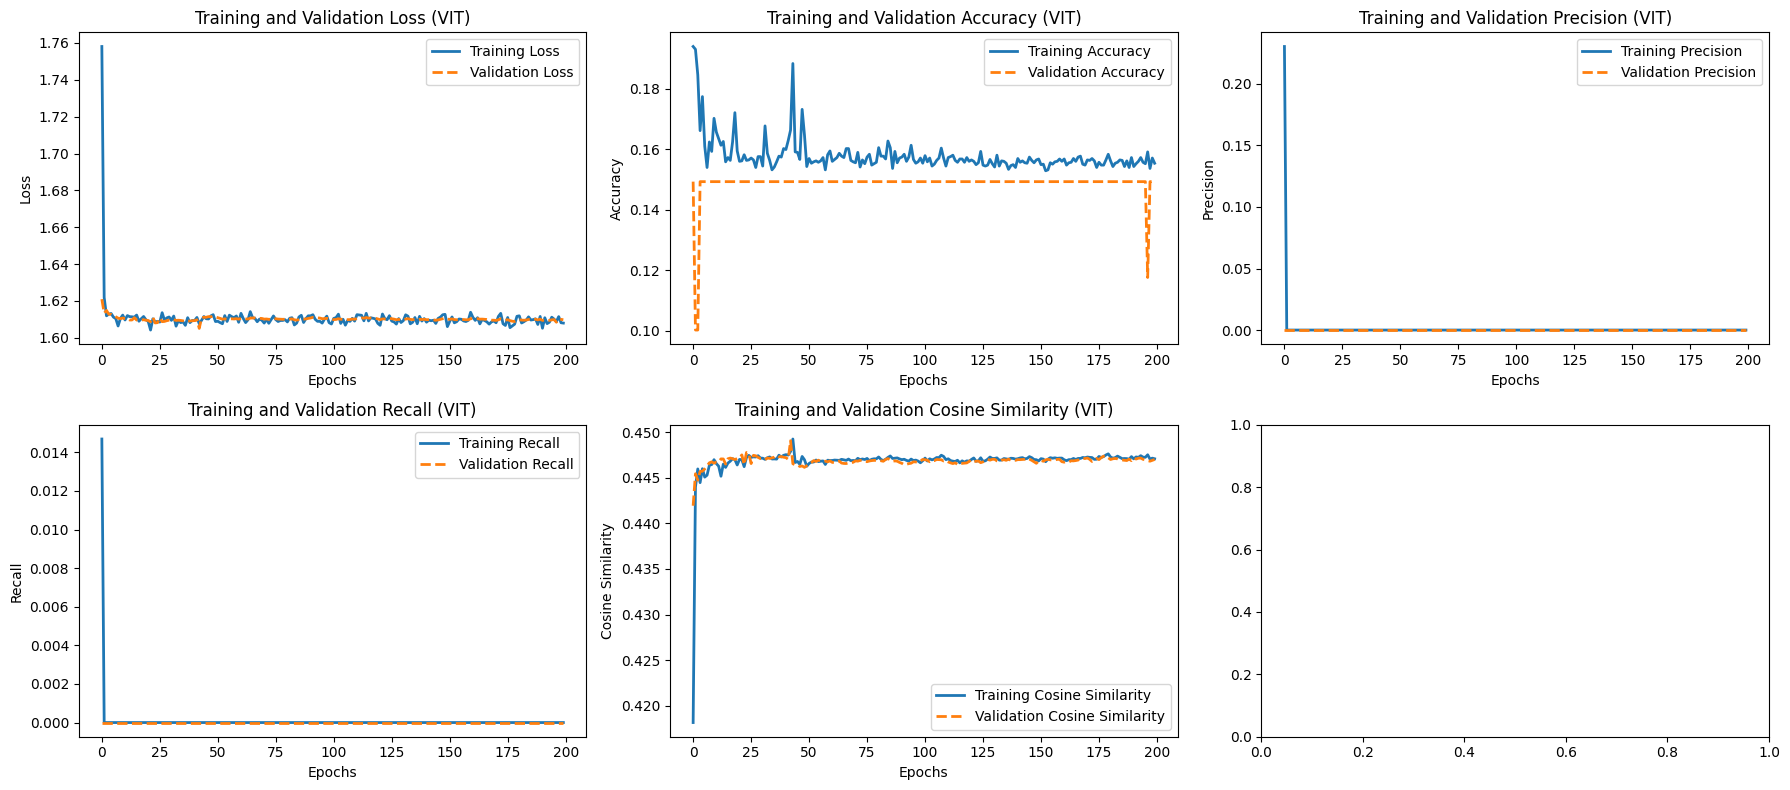

In [31]:
import matplotlib.pyplot as plt

# Create a single figure for all subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Plot training and validation loss
axes[0, 0].plot(vit_train_losses, label='Training Loss', linestyle='-', linewidth=2)
axes[0, 0].plot(vit_val_losses, label='Validation Loss', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].set_title('Training and Validation Loss (VIT)')

# Plot training and validation accuracy
axes[0, 1].plot(vit_train_accuracies, label='Training Accuracy', linestyle='-', linewidth=2)
axes[0, 1].plot(vit_val_accuracies, label='Validation Accuracy', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].set_title('Training and Validation Accuracy (VIT)')

# Plot precision, recall, and cosine similarity
axes[0, 2].plot(vit_train_precisions, label='Training Precision', linestyle='-', linewidth=2)
axes[0, 2].plot(vit_val_precisions, label='Validation Precision', linestyle='--', linewidth=2)
axes[0, 2].set_xlabel('Epochs')
axes[0, 2].set_ylabel('Precision')
axes[0, 2].legend()
axes[0, 2].set_title('Training and Validation Precision (VIT)')

axes[1, 0].plot(vit_train_recalls, label='Training Recall', linestyle='-', linewidth=2)
axes[1, 0].plot(vit_val_recalls, label='Validation Recall', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].legend()
axes[1, 0].set_title('Training and Validation Recall (VIT)')

axes[1, 1].plot(vit_train_cosine_similarity, label='Training Cosine Similarity', linestyle='-', linewidth=2)
axes[1, 1].plot(vit_val_cosine_similarity, label='Validation Cosine Similarity', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Cosine Similarity')
axes[1, 1].legend()
axes[1, 1].set_title('Training and Validation Cosine Similarity (VIT)')

# Ensure that the layout is tight
plt.tight_layout()

plt.show()

In [32]:
# Values are from table 4.
patch_size = 4  # 2x2, for the Transformer blocks.
image_size = 80
expansion_factor = 2  # expansion factor for the MobileNetV2 blocks.
batch_size = 64
auto = tf.data.AUTOTUNE
num_classes = 5
learning_rate = 0.002
label_smoothing_factor = 0.1
epochs = 100

In [33]:

from keras.applications import imagenet_utils

def conv_block(x, filters=16, kernel_size=3, strides=2):
    conv_layer = layers.Conv2D(
        filters, kernel_size, strides=strides, activation=tf.nn.swish, padding="same"
    )
    return conv_layer(x)


# Reference: https://git.io/JKgtC


def inverted_residual_block(x, expanded_channels, output_channels, strides=1):
    m = layers.Conv2D(expanded_channels, 1, padding="same", use_bias=False)(x)
    m = layers.BatchNormalization()(m)
    m = tf.nn.swish(m)

    m = layers.BatchNormalization()(m)
    m = tf.nn.swish(m)

    m = layers.Conv2D(output_channels, 1, padding="same", use_bias=False)(m)
    m = layers.BatchNormalization()(m)

    if tf.math.equal(x.shape[-1], output_channels) and strides == 1:
        return layers.Add()([m, x])
    return m


# Reference:
# https://keras.io/examples/vision/image_classification_with_vision_transformer/


def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.swish)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


def transformer_block(x, transformer_layers, projection_dim, num_heads=2):
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=[x.shape[-1] * 2, x.shape[-1]], dropout_rate=0.1,)
        # Skip connection 2.
        x = layers.Add()([x3, x2])

    return x


def mobilevit_block(x, num_blocks, projection_dim, strides=1):
    # Local projection with a single 3x3 convolution.
    local_features = layers.Conv2D(projection_dim, kernel_size=3, strides=strides, padding='same')(x)

    # Fold into conv-like feature-maps.
    folded_feature_map = layers.Conv2D(x.shape[-1], kernel_size=1, strides=strides, padding='same')(local_features)

    # Combine the folded feature map with the input features.
    local_global_features = layers.Concatenate(axis=-1)([x, folded_feature_map])

    return local_global_features

In [34]:
def create_mobilevit(num_classes=5):
    inputs = keras.Input((image_size, image_size, 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Initial conv-stem -> MV2 block.
    x = conv_block(x, filters=16)
    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=16
    )

    # Downsampling with MV2 block.
    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=24, strides=2
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )

    # First MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=48, strides=2
    )
    x = mobilevit_block(x, num_blocks=2, projection_dim=64)

    # Second MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=64 * expansion_factor, output_channels=64, strides=2
    )
    x = mobilevit_block(x, num_blocks=4, projection_dim=80)

    # Third MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=80 * expansion_factor, output_channels=80, strides=2
    )
    x = mobilevit_block(x, num_blocks=3, projection_dim=96)
    x = conv_block(x, filters=320, kernel_size=1, strides=1)

    # Classification head.
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)


mobilevit = create_mobilevit()
mobilevit.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 80, 80, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 80, 80, 3)            0         ['input_4[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 40, 40, 16)           448       ['rescaling[0][0]']           
                                                                                                  
 conv2d_1 (Conv2D)           (None, 40, 40, 32)           512       ['conv2d[0][0]']              
                                                                                            

In [35]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # You can choose any metric to monitor
    patience=30,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True  # Do restore best weights
)

# Compile the model
mobilevit.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_categorical_accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.CosineSimilarity(name='cosine_similarity')
    ]
)

# Initialize variables to keep track of the best validation loss and corresponding model weights
best_val_loss = float('inf')
best_weights = None

# Lists to store training and validation metrics
mobilevit_train_losses = []
mobilevit_val_losses = []
mobilevit_train_accuracies = []
mobilevit_val_accuracies = []
mobilevit_train_precisions = []
mobilevit_val_precisions = []
mobilevit_train_recalls = []
mobilevit_val_recalls = []
mobilevit_train_cosine_similarity = []
mobilevit_val_cosine_similarity = []

for epoch in range(200):
    # Train the model for one epoch
    history = mobilevit.fit(train_ds, epochs=1, validation_data=val_ds,steps_per_epoch = 100, callbacks=[early_stopping],class_weight = class_weights)
    #history = mobilevit.fit(train_ds, epochs=1, validation_data=val_ds,steps_per_epoch = 100, callbacks=[early_stopping])
    # Append training and validation metrics for plotting
    mobilevit_train_losses.append(history.history['loss'][0])
    mobilevit_val_losses.append(history.history['val_loss'][0])
    mobilevit_train_accuracies.append(history.history['categorical_accuracy'][0])
    mobilevit_val_accuracies.append(history.history['val_categorical_accuracy'][0])
    mobilevit_train_precisions.append(history.history['precision'][0])
    mobilevit_val_precisions.append(history.history['val_precision'][0])
    mobilevit_train_recalls.append(history.history['recall'][0])
    mobilevit_val_recalls.append(history.history['val_recall'][0])
    mobilevit_train_cosine_similarity.append(history.history['cosine_similarity'][0])
    mobilevit_val_cosine_similarity.append(history.history['val_cosine_similarity'][0])

    # Check if the current validation loss is better than the best seen so far
    if history.history['val_loss'][0] < best_val_loss:
        best_val_loss = history.history['val_loss'][0]
        best_weights = mobilevit.get_weights()
        # You can also save the weights to a file here if desired

# After training, you can set the model weights to the best weights
mobilevit.set_weights(best_weights)

# Now you have the training and validation metrics (loss, accuracy, precision, recall, and cosine similarity) stored in the respective lists.

100/100 [==============================] - 24s 235ms/step - loss: 0.0021 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 0.9999 - val_loss: 694.6609 - val_categorical_accuracy: 0.1002 - val_top_5_categorical_accuracy: 1.0000 - val_precision: 0.1002 - val_recall: 0.1002 - val_cosine_similarity: 0.1002


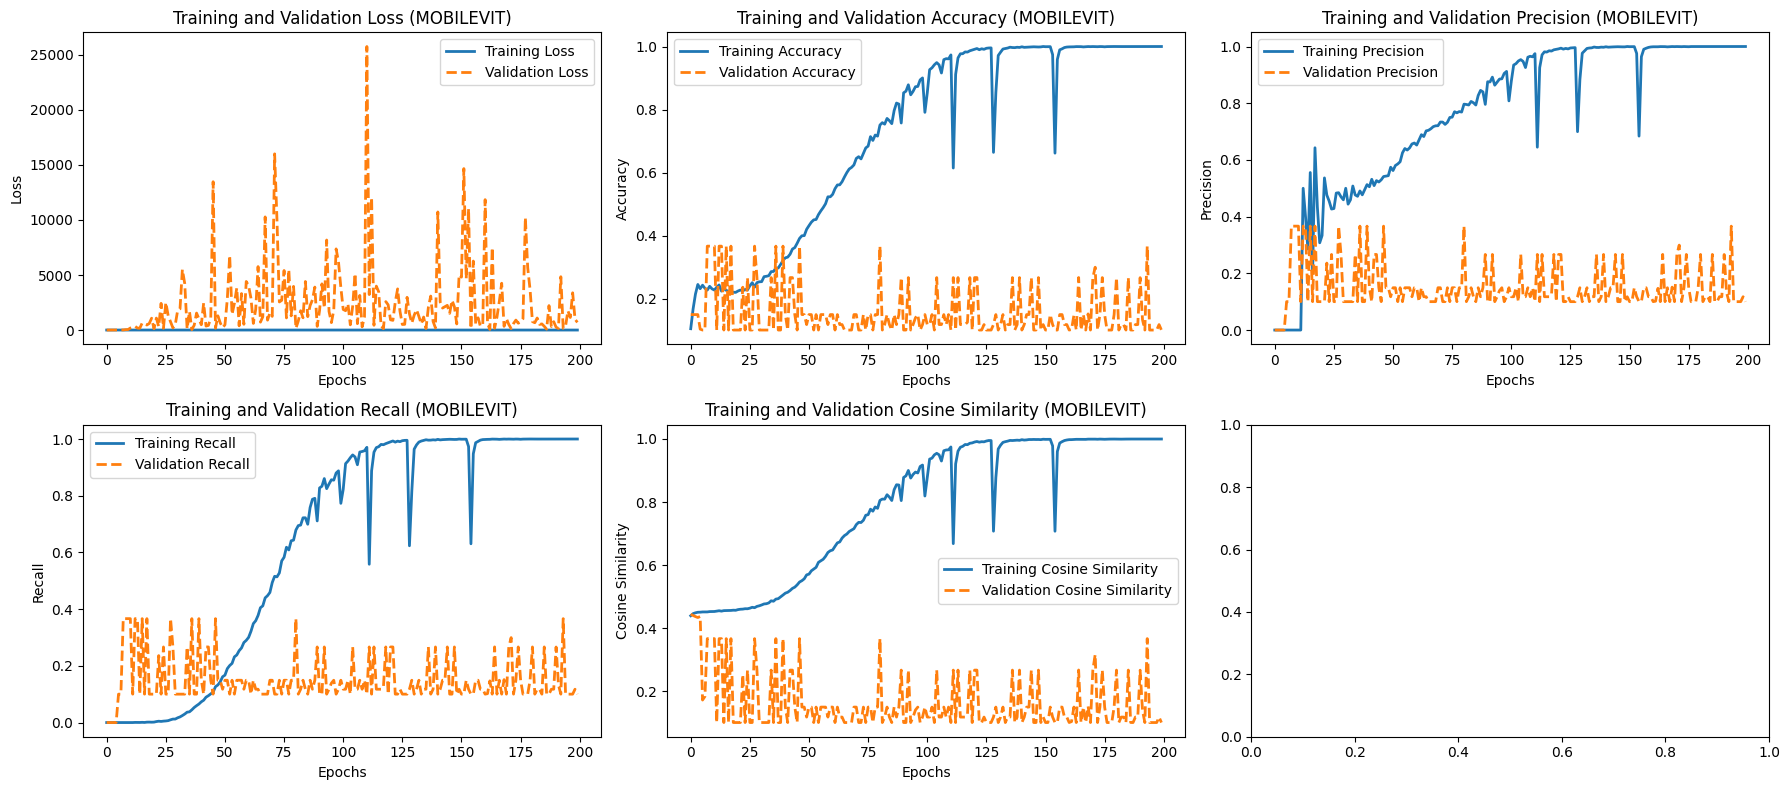

In [36]:
import matplotlib.pyplot as plt

# Create a single figure for all subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Plot training and validation loss
axes[0, 0].plot(mobilevit_train_losses, label='Training Loss', linestyle='-', linewidth=2)
axes[0, 0].plot(mobilevit_val_losses, label='Validation Loss', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].set_title('Training and Validation Loss (MOBILEVIT)')

# Plot training and validation accuracy
axes[0, 1].plot(mobilevit_train_accuracies, label='Training Accuracy', linestyle='-', linewidth=2)
axes[0, 1].plot(mobilevit_val_accuracies, label='Validation Accuracy', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].set_title('Training and Validation Accuracy (MOBILEVIT)')

# Plot precision, recall, and cosine similarity
axes[0, 2].plot(mobilevit_train_precisions, label='Training Precision', linestyle='-', linewidth=2)
axes[0, 2].plot(mobilevit_val_precisions, label='Validation Precision', linestyle='--', linewidth=2)
axes[0, 2].set_xlabel('Epochs')
axes[0, 2].set_ylabel('Precision')
axes[0, 2].legend()
axes[0, 2].set_title('Training and Validation Precision (MOBILEVIT)')

axes[1, 0].plot(mobilevit_train_recalls, label='Training Recall', linestyle='-', linewidth=2)
axes[1, 0].plot(mobilevit_val_recalls, label='Validation Recall', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].legend()
axes[1, 0].set_title('Training and Validation Recall (MOBILEVIT)')

axes[1, 1].plot(mobilevit_train_cosine_similarity, label='Training Cosine Similarity', linestyle='-', linewidth=2)
axes[1, 1].plot(mobilevit_val_cosine_similarity, label='Validation Cosine Similarity', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Cosine Similarity')
axes[1, 1].legend()
axes[1, 1].set_title('Training and Validation Cosine Similarity (MOBILEVIT)')

# Ensure that the layout is tight
plt.tight_layout()

plt.show()

In [37]:
positional_emb = False
conv_layers = 1
projection_dim = 64

num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]
transformer_layers = 2
stochastic_depth_rate = 0.1

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 100
image_size = 80

In [38]:
class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        # Positional embeddings are optional in CCT. Here, we calculate
        # the number of sequences and initialize an `Embedding` layer to
        # compute the positional embeddings later.
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

In [39]:
# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (tf.shape(x).shape[0] - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

In [40]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [41]:
def create_cct_model(
    image_size=image_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_layers=200,  # Increase the number of transformer layers
    hidden_dim=16384,        # Increase the hidden dimension
    stochastic_depth_rate=0.1,
    num_classes=num_classes,
):
    inputs = layers.Input(input_shape)



    # Multi-Head Self-Attention Block
    for i in range(transformer_layers):

        # Encode patches.
        cct_tokenizer = CCTTokenizer()
        encoded_patches = cct_tokenizer(inputs)

        # Calculate Stochastic Depth probabilities.
        dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

        x = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Skip connection
        attention_output = layers.Dropout(rate=dpr[i])(x)
        encoded_patches = layers.Add()([attention_output, encoded_patches])

    # Sequence Pooling
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)

    # Feedforward layers with increased hidden dimension
    x = layers.Dense(hidden_dim, activation="relu")(weighted_representation)
    x = layers.Dropout(0.5)(x)

    # Classification Layer
    logits = layers.Dense(num_classes, activation="softmax")(x)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [42]:
cct = create_cct_model()

cct.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 80, 80, 3)]          0         []                            
                                                                                                  
 cct_tokenizer_199 (CCTToke  (None, 1600, 64)             1728      ['input_5[0][0]']             
 nizer)                                                                                           
                                                                                                  
 layer_normalization_227 (L  (None, 1600, 64)             128       ['cct_tokenizer_199[0][0]']   
 ayerNormalization)                                                                               
                                                                                            

In [43]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # You can choose any metric to monitor
    patience=30,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True  # Do restore best weights
)

# Compile the model
cct.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_categorical_accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.CosineSimilarity(name='cosine_similarity')
    ]
)

# Initialize variables to keep track of the best validation loss and corresponding model weights
best_val_loss = float('inf')
best_weights = None

# Lists to store training and validation metrics
cct_train_losses = []
cct_val_losses = []
cct_train_accuracies = []
cct_val_accuracies = []
cct_train_precisions = []
cct_val_precisions = []
cct_train_recalls = []
cct_val_recalls = []
cct_train_cosine_similarity = []
cct_val_cosine_similarity = []

for epoch in range(200):
    # Train the model for one epoch
    history = cct.fit(train_ds, epochs=1, validation_data=val_ds,steps_per_epoch = 100, callbacks=[early_stopping],class_weight = class_weights)
    #history = cct.fit(train_ds, epochs=1, validation_data=val_ds,steps_per_epoch = 100, callbacks=[early_stopping])
    # Append training and validation metrics for plotting
    cct_train_losses.append(history.history['loss'][0])
    cct_val_losses.append(history.history['val_loss'][0])
    cct_train_accuracies.append(history.history['categorical_accuracy'][0])
    cct_val_accuracies.append(history.history['val_categorical_accuracy'][0])
    cct_train_precisions.append(history.history['precision'][0])
    cct_val_precisions.append(history.history['val_precision'][0])
    cct_train_recalls.append(history.history['recall'][0])
    cct_val_recalls.append(history.history['val_recall'][0])
    cct_train_cosine_similarity.append(history.history['cosine_similarity'][0])
    cct_val_cosine_similarity.append(history.history['val_cosine_similarity'][0])

    # Check if the current validation loss is better than the best seen so far
    if history.history['val_loss'][0] < best_val_loss:
        best_val_loss = history.history['val_loss'][0]
        best_weights = cct.get_weights()
        # You can also save the weights to a file here if desired

# After training, you can set the model weights to the best weights
cct.set_weights(best_weights)

# Now you have the training and validation metrics (loss, accuracy, precision, recall, and cosine similarity) stored in the respective lists.

100/100 [==============================] - 7s 67ms/step - loss: 1.4883 - categorical_accuracy: 0.2917 - top_5_categorical_accuracy: 1.0000 - precision: 0.5496 - recall: 0.0113 - cosine_similarity: 0.4834 - val_loss: 1.5429 - val_categorical_accuracy: 0.2668 - val_top_5_categorical_accuracy: 1.0000 - val_precision: 0.4210 - val_recall: 0.0196 - val_cosine_similarity: 0.4673


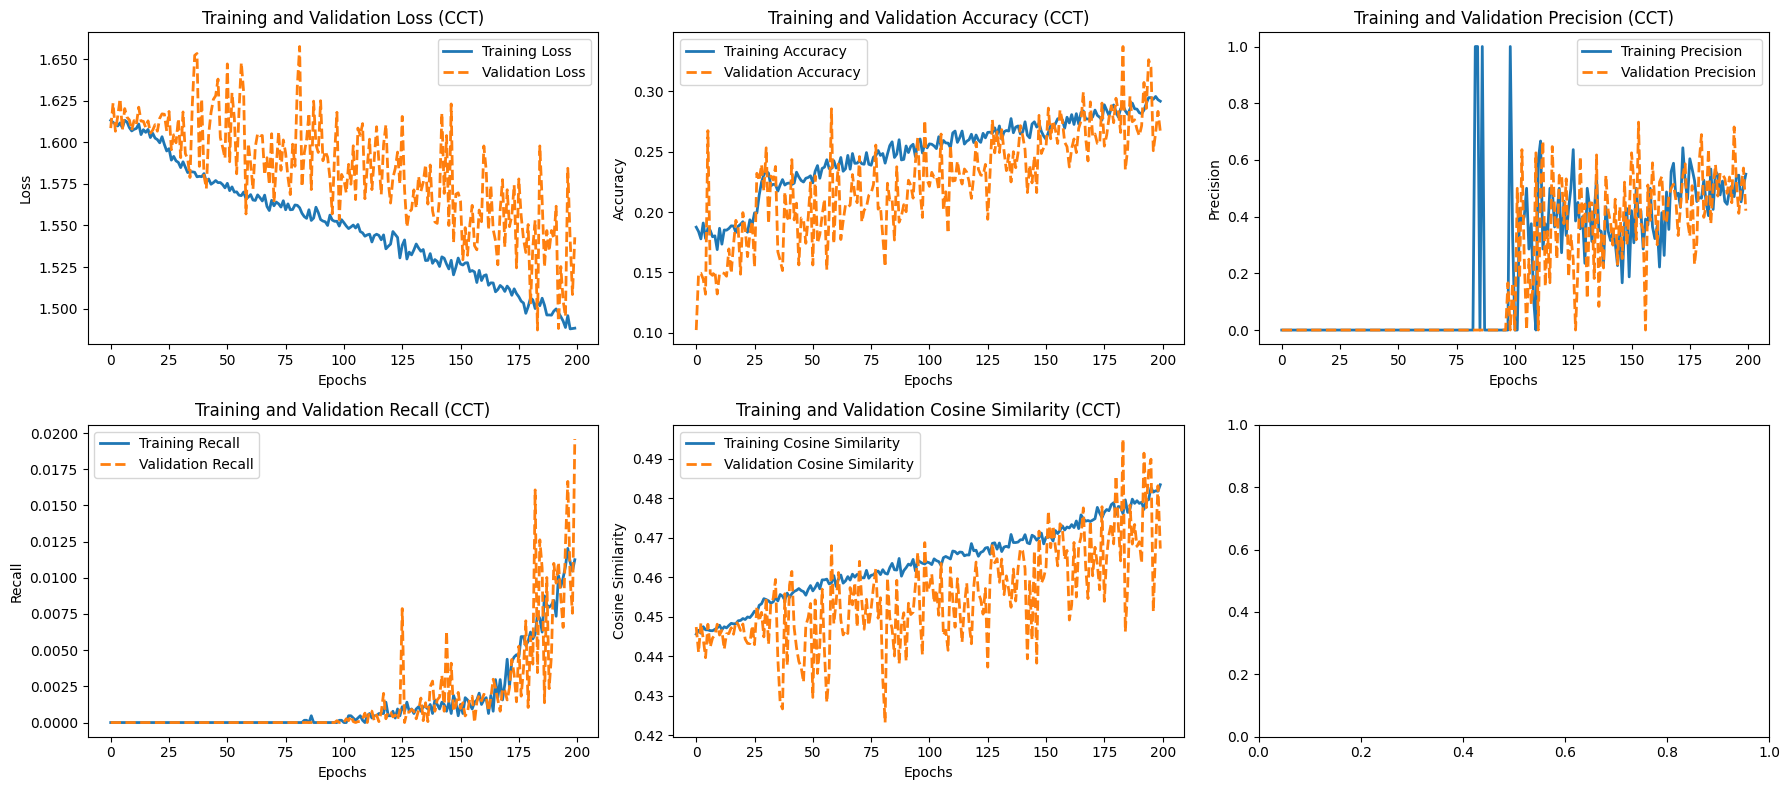

In [44]:
import matplotlib.pyplot as plt

# Create a single figure for all subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Plot training and validation loss
axes[0, 0].plot(cct_train_losses, label='Training Loss', linestyle='-', linewidth=2)
axes[0, 0].plot(cct_val_losses, label='Validation Loss', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].set_title('Training and Validation Loss (CCT)')

# Plot training and validation accuracy
axes[0, 1].plot(cct_train_accuracies, label='Training Accuracy', linestyle='-', linewidth=2)
axes[0, 1].plot(cct_val_accuracies, label='Validation Accuracy', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].set_title('Training and Validation Accuracy (CCT)')

# Plot precision, recall, and cosine similarity
axes[0, 2].plot(cct_train_precisions, label='Training Precision', linestyle='-', linewidth=2)
axes[0, 2].plot(cct_val_precisions, label='Validation Precision', linestyle='--', linewidth=2)
axes[0, 2].set_xlabel('Epochs')
axes[0, 2].set_ylabel('Precision')
axes[0, 2].legend()
axes[0, 2].set_title('Training and Validation Precision (CCT)')

axes[1, 0].plot(cct_train_recalls, label='Training Recall', linestyle='-', linewidth=2)
axes[1, 0].plot(cct_val_recalls, label='Validation Recall', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].legend()
axes[1, 0].set_title('Training and Validation Recall (CCT)')

axes[1, 1].plot(cct_train_cosine_similarity, label='Training Cosine Similarity', linestyle='-', linewidth=2)
axes[1, 1].plot(cct_val_cosine_similarity, label='Validation Cosine Similarity', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Cosine Similarity')
axes[1, 1].legend()
axes[1, 1].set_title('Training and Validation Cosine Similarity (CCT)')

# Ensure that the layout is tight
plt.tight_layout()

plt.show()

In [45]:
import os

# Define the directory path where you want to save the models
#path = "50K" #Initial
path = "50K_Cost_sensitive" #Initial
#path = "25K" #Augmented

# Ensure that the directory path exists, or create it if it doesn't
if not os.path.exists(path):
    os.makedirs(path)

# Evaluate the model
evaluation_results = swin.evaluate(test_ds, batch_size=32)
print("Evaluation results:", evaluation_results)
# Save the trained model to a file
#swin.save(f"{path}/swin.h5")
print("Model saved to", f"{path}/swin.h5")

# Evaluate the model
evaluation_results = vit.evaluate(test_ds, batch_size=32)
print("Evaluation results:", evaluation_results)
# Save the trained model to a file
#vit.save(f"{path}/vit.h5")
print("Model saved to", f"{path}/vit.h5")

# Evaluate the model
evaluation_results = mobilevit.evaluate(test_ds, batch_size=32)
print("Evaluation results:", evaluation_results)
# Save the trained model to a file
#mobilevit.save(f"{path}/mobilevit.h5")
print("Model saved to", f"{path}/mobilevit.h5")

# Evaluate the model
evaluation_results = cct.evaluate(test_ds, batch_size=32)
print("Evaluation results:", evaluation_results)
# Save the trained model to a file
#cct.save(f"{path}/cct.h5")
print("Model saved to", f"{path}/cct.h5")


241/241 [==============================] - 63s 262ms/step - loss: 1.5951 - categorical_accuracy: 0.1517 - top_5_categorical_accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - cosine_similarity: 0.4530
Evaluation results: [1.595070719718933, 0.15171830356121063, 1.0, 0.0, 0.0, 0.45296332240104675]
Model saved to 50K_Cost_sensitive/swin.h5
241/241 [==============================] - 2s 7ms/step - loss: 1.6051 - categorical_accuracy: 0.1492 - top_5_categorical_accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - cosine_similarity: 0.4491
Evaluation results: [1.6050606966018677, 0.1492449939250946, 1.0, 0.0, 0.0, 0.44909900426864624]
Model saved to 50K_Cost_sensitive/vit.h5
241/241 [==============================] - 10s 42ms/step - loss: 1.6169 - categorical_accuracy: 0.1492 - top_5_categorical_accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - cosine_similarity: 0.4439
Evaluation results: [1.616857886314392, 0.1492449939250946, 1.0, 0.0, 0.0, 0.44387078

241/241 [==============================] - 62s 257ms/step


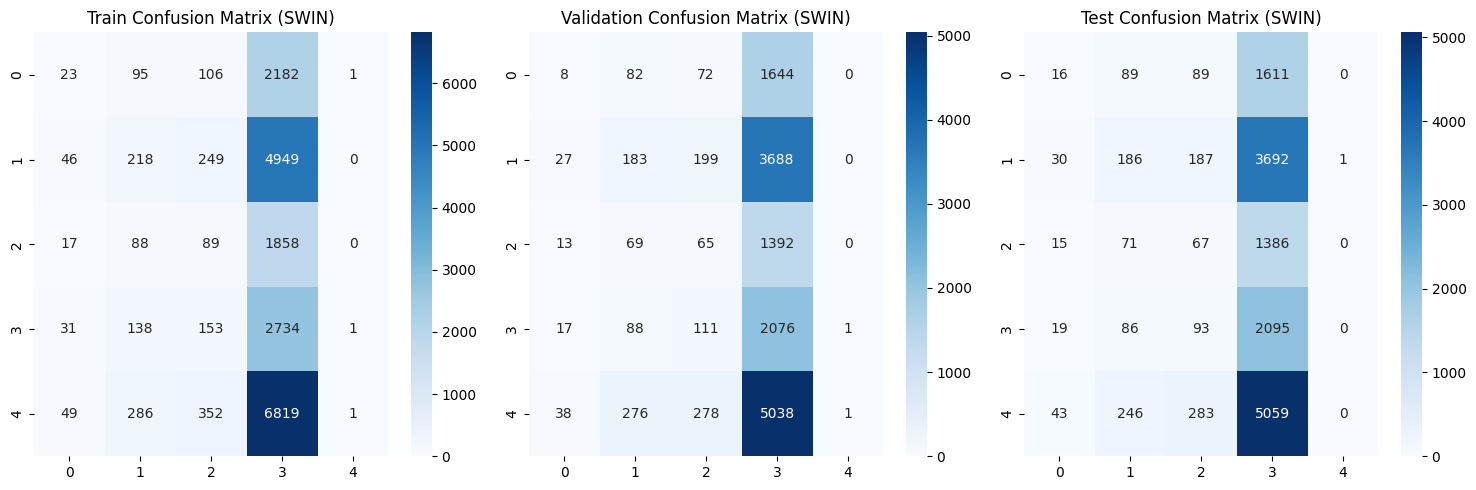

In [46]:
# Generate predictions for train, validation, and test datasets
train_predictions = swin.predict(train_ds)
val_predictions = swin.predict(val_ds)
test_predictions = swin.predict(test_ds)

# Convert predictions to class labels
train_pred_labels = np.argmax(train_predictions, axis=1)
val_pred_labels = np.argmax(val_predictions, axis=1)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Get true labels for training, validation, and test datasets
train_true_labels = np.concatenate([y for _, y in train_ds], axis=0)
val_true_labels = np.concatenate([y for _, y in val_ds], axis=0)
test_true_labels = np.concatenate([y for _, y in test_ds], axis=0)

# Convert one-hot encoded labels to integer labels
train_true_labels = np.argmax(train_true_labels, axis=1)
val_true_labels = np.argmax(val_true_labels, axis=1)
test_true_labels = np.argmax(test_true_labels, axis=1)

# Calculate confusion matrices
train_conf_matrix = confusion_matrix(train_true_labels, train_pred_labels)
val_conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)
test_conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)

# Plot confusion matrices
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Train Confusion Matrix (SWIN)')

plt.subplot(1, 3, 2)
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix (SWIN)')

plt.subplot(1, 3, 3)
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix (SWIN)')

plt.tight_layout()
plt.show()

241/241 [==============================] - 1s 6ms/step


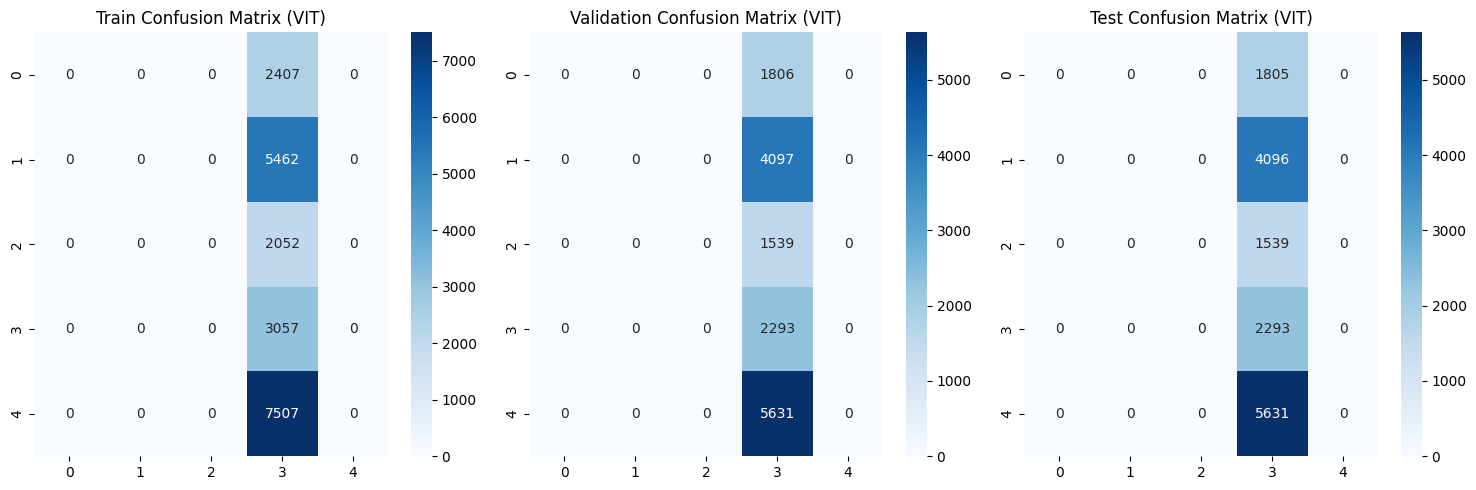

In [47]:
# Generate predictions for train, validation, and test datasets
train_predictions = vit.predict(train_ds)
val_predictions = vit.predict(val_ds)
test_predictions = vit.predict(test_ds)

# Convert predictions to class labels
train_pred_labels = np.argmax(train_predictions, axis=1)
val_pred_labels = np.argmax(val_predictions, axis=1)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Get true labels for training, validation, and test datasets
train_true_labels = np.concatenate([y for _, y in train_ds], axis=0)
val_true_labels = np.concatenate([y for _, y in val_ds], axis=0)
test_true_labels = np.concatenate([y for _, y in test_ds], axis=0)

# Convert one-hot encoded labels to integer labels
train_true_labels = np.argmax(train_true_labels, axis=1)
val_true_labels = np.argmax(val_true_labels, axis=1)
test_true_labels = np.argmax(test_true_labels, axis=1)

# Calculate confusion matrices
train_conf_matrix = confusion_matrix(train_true_labels, train_pred_labels)
val_conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)
test_conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)

# Plot confusion matrices
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Train Confusion Matrix (VIT)')

plt.subplot(1, 3, 2)
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix (VIT)')

plt.subplot(1, 3, 3)
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix (VIT)')

plt.tight_layout()
plt.show()

241/241 [==============================] - 9s 37ms/step


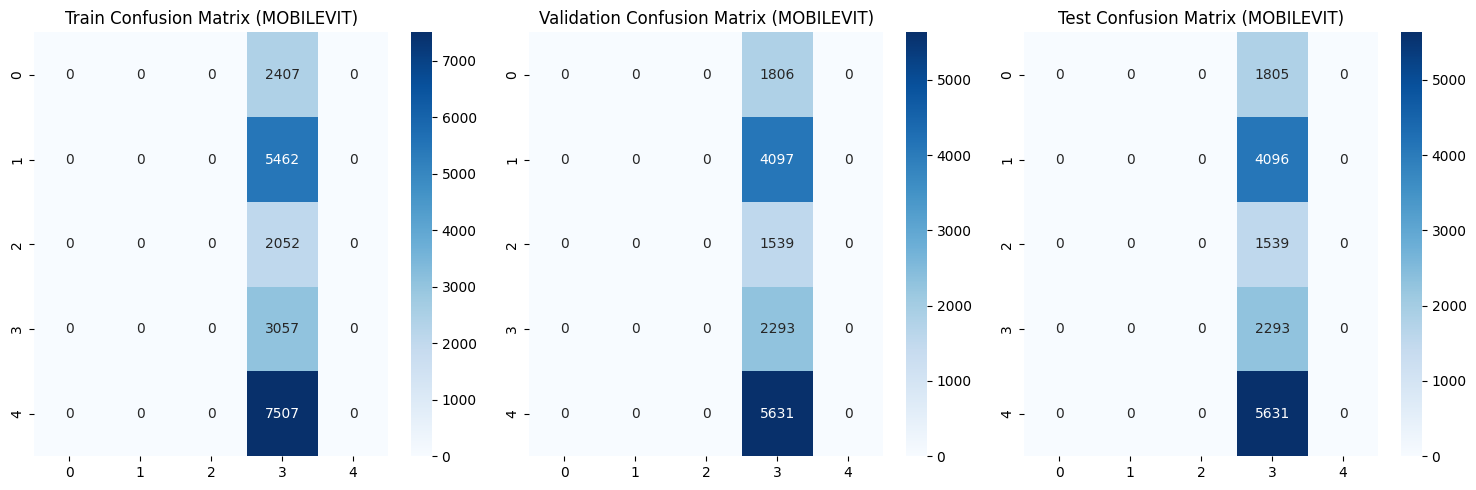

In [48]:
# Generate predictions for train, validation, and test datasets
train_predictions = mobilevit.predict(train_ds)
val_predictions = mobilevit.predict(val_ds)
test_predictions = mobilevit.predict(test_ds)

# Convert predictions to class labels
train_pred_labels = np.argmax(train_predictions, axis=1)
val_pred_labels = np.argmax(val_predictions, axis=1)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Get true labels for training, validation, and test datasets
train_true_labels = np.concatenate([y for _, y in train_ds], axis=0)
val_true_labels = np.concatenate([y for _, y in val_ds], axis=0)
test_true_labels = np.concatenate([y for _, y in test_ds], axis=0)

# Convert one-hot encoded labels to integer labels
train_true_labels = np.argmax(train_true_labels, axis=1)
val_true_labels = np.argmax(val_true_labels, axis=1)
test_true_labels = np.argmax(test_true_labels, axis=1)

# Calculate confusion matrices
train_conf_matrix = confusion_matrix(train_true_labels, train_pred_labels)
val_conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)
test_conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)

# Plot confusion matrices
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Train Confusion Matrix (MOBILEVIT)')

plt.subplot(1, 3, 2)
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix (MOBILEVIT)')

plt.subplot(1, 3, 3)
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix (MOBILEVIT)')

plt.tight_layout()
plt.show()

241/241 [==============================] - 3s 12ms/step


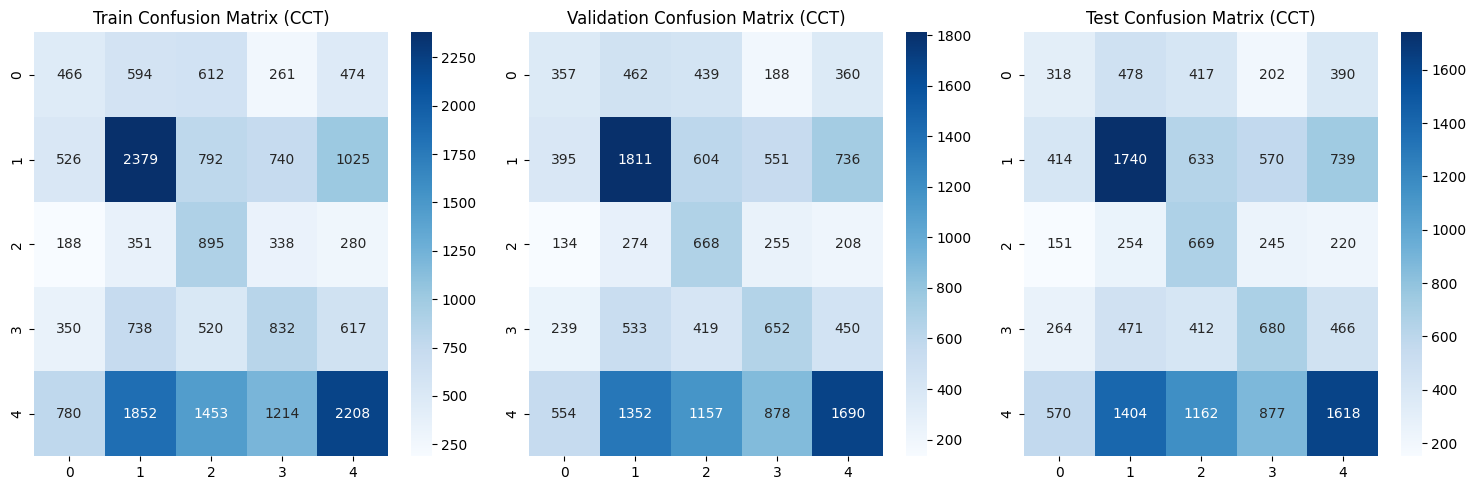

In [49]:
# Generate predictions for train, validation, and test datasets
train_predictions = cct.predict(train_ds)
val_predictions = cct.predict(val_ds)
test_predictions = cct.predict(test_ds)

# Convert predictions to class labels
train_pred_labels = np.argmax(train_predictions, axis=1)
val_pred_labels = np.argmax(val_predictions, axis=1)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Get true labels for training, validation, and test datasets
train_true_labels = np.concatenate([y for _, y in train_ds], axis=0)
val_true_labels = np.concatenate([y for _, y in val_ds], axis=0)
test_true_labels = np.concatenate([y for _, y in test_ds], axis=0)

# Convert one-hot encoded labels to integer labels
train_true_labels = np.argmax(train_true_labels, axis=1)
val_true_labels = np.argmax(val_true_labels, axis=1)
test_true_labels = np.argmax(test_true_labels, axis=1)

# Calculate confusion matrices
train_conf_matrix = confusion_matrix(train_true_labels, train_pred_labels)
val_conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)
test_conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)

# Plot confusion matrices
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Train Confusion Matrix (CCT)')

plt.subplot(1, 3, 2)
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix (CCT)')

plt.subplot(1, 3, 3)
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix (CCT)')

plt.tight_layout()
plt.show()

In [50]:
#pip install shap

In [51]:
'''
import shap
import matplotlib.pyplot as plt

# Choose an image from the test dataset
image_index = 0  # Change this to the index of the image you want to explain

# Extract the specific image and label using a loop
for i, (image, label) in enumerate(test_ds):
    if i == image_index:
        chosen_image = image
        chosen_label = label
        break

# Create a SHAP explainer with a higher max_evals value
num_features = 300 * 300 * 3  # Number of features in your image
max_evals = 2 * num_features + 1  # Minimum required value
explainer = shap.Explainer(cnn, test_ds.map(lambda x, y: x), max_evals=max_evals)

# Calculate SHAP values for the chosen image
shap_values = explainer(chosen_image)

# Choose the class you want to explain (e.g., class 0)
class_to_explain = 0

# Get the expected value (baseline) for the model's output
expected_value = explainer.expected_value[class_to_explain]

# Plot the SHAP values as an overlay on the image
shap.image_plot(shap_values[class_to_explain], chosen_image.numpy(), show=False)
# Add a title to the plot
plt.title(f'SHAP Explanation for Class {class_to_explain}, Expected Value: {expected_value:.2f}')
# Show the plot
plt.show()
'''

"\nimport shap\nimport matplotlib.pyplot as plt\n\n# Choose an image from the test dataset\nimage_index = 0  # Change this to the index of the image you want to explain\n\n# Extract the specific image and label using a loop\nfor i, (image, label) in enumerate(test_ds):\n    if i == image_index:\n        chosen_image = image\n        chosen_label = label\n        break\n\n# Create a SHAP explainer with a higher max_evals value\nnum_features = 300 * 300 * 3  # Number of features in your image\nmax_evals = 2 * num_features + 1  # Minimum required value\nexplainer = shap.Explainer(cnn, test_ds.map(lambda x, y: x), max_evals=max_evals)\n\n# Calculate SHAP values for the chosen image\nshap_values = explainer(chosen_image)\n\n# Choose the class you want to explain (e.g., class 0)\nclass_to_explain = 0\n\n# Get the expected value (baseline) for the model's output\nexpected_value = explainer.expected_value[class_to_explain]\n\n# Plot the SHAP values as an overlay on the image\nshap.image_plot(s